In [1]:
from typing import Tuple
import scipy.sparse
from typing import Tuple, Dict, Hashable

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

colors = np.array(['tab:blue', 'orange'])

## Connections to Heat Diffusion

Remember that in Heat Diffusion we were minimizing the variational quantity
$$ f(\mathbf{x}) = \frac{1}{2}\mathbf{x}^T \mathbf{L} \mathbf{x}$$
w.r.t the norm $\|\cdot\|_{\mathbf{D}}$.

For semisupervised learning we are going to add a regression term for the label set $\ell$ that is known
$$f(\mathbf{x}) = \frac{1}{2}\mathbf{x}^T \mathbf{L} \mathbf{x} + \frac{\lambda}{2}\sum_{i \in \ell} d_i(x_i - s_i)^2 = \frac{1}{2}\mathbf{x}^T \mathbf{L} \mathbf{x} + \frac{\lambda}{2} \|\mathbf{x}_{\ell} - \mathbf{s}_\ell\|_{\mathbf{D}}^2$$

You are given code that performs the unsupervised heat diffusion and need to add your own that incorporates the regression term.

In my (admittely limited) understanding of Matrix algebra, I believe the gradient of the function $f(x)$ changes to 
$$\nabla f(\textbf{x}) = \nabla \big[\frac{1}{2} \textbf{x}^\intercal L\textbf{x} + \frac{\lambda}{2}\lVert x_\ell - s_\ell \rVert _D^2\big]$$

Since the gradient operator is linear, the first term stays the same, i.e.
$$\nabla f(\textbf{x}) = L\textbf{x}  + \nabla \big[\frac{\lambda}{2}\lVert \textbf{x}_\ell - s_\ell \rVert _D^2\big]$$

We can expand the term being differentiated to
$$\frac{\lambda}{2}\lVert x_\ell - s_\ell \rVert _D^2 = \frac{\lambda}{2}\Big[ (\textbf{x}_\ell - \textbf{s}_\ell)^\intercal D (\textbf{x}_\ell - \textbf{s}_\ell) \Big]$$
$$= \frac{\lambda}{2}\Big[ \textbf{x}_\ell^\intercal D \textbf{x}_\ell - \textbf{x}_\ell^\intercal D \textbf{s}_\ell - \textbf{s}_\ell^\intercal D\textbf{x}_\ell - \textbf{s}_\ell D\textbf{s}_\ell\Big]$$

Taking the derivative of this, with respect to \textbf{x}, gives, 
$$\frac{\lambda}{2}\nabla \big[ \lVert \textbf{x}_\ell - \textbf{s}_\ell \rVert _{D}^2 \big] = \frac{\lambda}{2}\Big[ \textbf{x}_\ell^\intercal D + \textbf{x}_\ell^\intercal D - \textbf{s}_\ell^\intercal D - \textbf{s}_\ell^\intercal D\Big] = \lambda D(\textbf{x}_\ell -\textbf{s}_\ell)$$

Therefore, the gradient for the new energy function is 
$$\nabla f(\textbf{x}) = L\textbf{x} + \lambda D(\textbf{x}_\ell - \textbf{s}_\ell)$$

Note that we are expanding $L$ to $BWB^\intercal$. The flow through each node, $WB^\intercal x$, stays the same. So new_y isn't modified. The iteration of $\textbf{x}_{i}$, after simplification, is now
$$\textbf{x}_{i+1} = \textbf{x}_i - \frac{1}{2}\Big[ D^{-1} B \textbf{y}_t + \lambda  \textbf{x}_{\ell, t}\Big]$$
where $\textbf{x}_{\ell, t}$ is the $t$-th iteration of the labels present.

In [146]:


def heat_diffusion(G: nx.Graph, labels: np.ndarray, label_present: np.ndarray, lamda: float=1,
                   T: int=100) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Heat Diffusion
    
    Given a graph `G` and an initial `x_0` runs heat diffusion until $\mathcal{U}(\mathbf{x}) < \epsilon$.
    
    Parameters
    ----------
        G : nx.Graph
            Graph to run heat diffusion on.
        labels : np.ndarray
            Real numbers corresponding to the target label.
        label_present : np.ndarray
            Indicator of the corresponding node having its label revealed.
        lamda : float
            Parameter weight between the regression term and the graph regularization term
        T : int
            Number of iterations.
    
    Returns
    -------
        x : np.ndarray
            The T x n x d evolution of x_0.
        y : np.ndarray
            Flow going through each edge. Should be T x m x d
        fx: np.ndarray
            The value of U(x(t)) at each time t.
    """
    n = nx.number_of_nodes(G)
    m = nx.number_of_edges(G)
    x_0 = np.zeros((n, 1))
    assert x_0.shape[0] == n, "x_0 does not have the right shape."
    d = x_0.shape[1]
    
    degree = np.array([deg for _, deg in G.degree(weight='weight')])
    vol = degree.sum()
    D = scipy.sparse.diags(degree)
    D_inv = scipy.sparse.diags(1/degree)
    L = nx.laplacian_matrix(G)
    B = nx.incidence_matrix(G, oriented=True)
    W = scipy.sparse.diags([w if w is not None else 1 for w in nx.get_edge_attributes(G, 'weight').values()])
    
    # TODO: For semisupervised learning the variational energy function is
    #           f(x) = 0.5 * x^T L x + (lambda*0.5)*|x_{\ell} - s_{\ell}|_{D}^2
    #       Add code that computes the correct f(x) and $\nabla f(x) in order to compute $x_{t+1}$
    x_0 = np.array([x * ind for x, ind in zip(labels, label_present)])
    x = [x_0]
    y = [W @ B.T @ x_0]
    diffusion_term = (x_0 - labels).T @ D @ (x_0 - labels)
    fx = [0.5 * x_0.T @ L @ x_0 + (lamda*0.5)* diffusion_term]
    

    for i in range(T):
        x_ell = np.array([x_i*ind for x_i, ind in zip(x[-1], label_present)])
        new_x = x[-1] - 0.5 * (D_inv @ B @ y[-1] + lamda*(x_ell - labels))
        x.append(new_x)
        new_y = W @ B.T @ new_x
        y.append(new_y)
        diffusion_term = (x_ell - labels).T @ D @ (x_ell - labels)
        new_fx =0.5 * x[-1].T @ L @ x[-1] + (lamda*0.5)* diffusion_term
        fx.append(new_fx)

    
    x = np.array(x)
    y = np.array(y)
    fx = np.array(fx)
    return x, y, fx



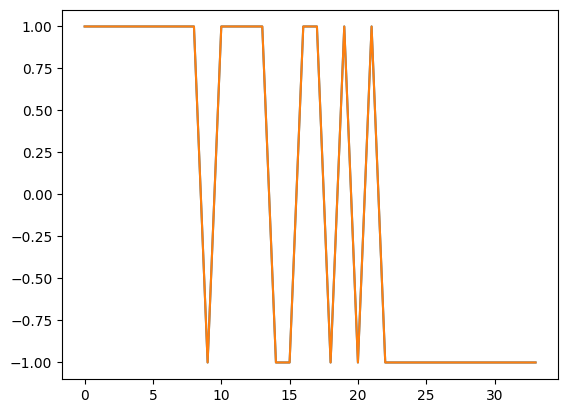

In [149]:
karate = nx.karate_club_graph()
nx.set_edge_attributes(karate, 1, 'weight')
karate_labels = np.array([1 if c == 'Mr. Hi' else -1 for v, c in karate.nodes(data='club')]).reshape(-1, 1)
karate_labels_present = np.zeros_like(karate_labels)
karate_labels_present[0] = 1
karate_labels_present[33] = 1
lamda = 1
x, y, fx = heat_diffusion(karate, karate_labels, karate_labels_present, lamda, T=100)

karate_predicted_label = (x[-1] >= 0).flatten().astype(int)

plt.plot(karate_predicted_label*2-1)
plt.plot(karate_labels)

#node_color = colors[karate_predicted_label]
#edge_color = [colors[karate_predicted_label[u]] if karate_predicted_label[u] == karate_predicted_label[v] else 'tab:red' for u, v in karate.edges]
#
#pos = nx.spring_layout(karate)
#pc = nx.draw(karate, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color, font_color='white')
plt.show()